In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 96% 233M/242M [00:04<00:00, 60.8MB/s]
100% 242M/242M [00:04<00:00, 61.5MB/s]


In [ ]:
!ls

amazon-fine-food-reviews.zip  gdrive  sample_data


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [ ]:
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt

 92% 121M/131M [00:01<00:00, 63.5MB/s] 
100% 131M/131M [00:01<00:00, 69.6MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [ ]:
word2Vec = {}
with open('glove.6B.100d.txt') as f:
  for line in f:
    line = line.rstrip().split(' ')
    word = line[0]
    embedding_vector = line[1:]
    word2Vec[word] = embedding_vector

list

In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed,Bidirectional , RepeatVector, Dot ,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore") 

In [ ]:
data= pd.read_csv("/content/Reviews.csv",nrows=100000,error_bad_lines=False)
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [ ]:
from nltk.stem import WordNetLemmatizer  
lemmatizer = WordNetLemmatizer() 
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = lemmatizer.lemmatize(text)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cleaned_text[:5]

['bought several Vitality canned dog food products found good quality. The product looks like stew processed meat smells better. Labrador finicky appreciates product better most.',
 'Product arrived labeled Jumbo Salted Peanuts...the peanuts actually small sized unsalted. Not sure error vendor intended represent product "Jumbo".',
 'This confection around centuries. light, pillowy citrus gelatin nuts case Filberts. And cut tiny squares liberally coated powdered sugar. And tiny mouthful heaven. Not chewy, flavorful. highly recommend yummy treat. familiar story C.S. Lewis\' "The Lion, The Witch, The Wardrobe" treat seduces Edmund selling Brother Sisters Witch.',
 'looking secret ingredient Robitussin believe found it. got addition Root Beer Extract ordered (which good) made cherry soda. The flavor medicinal.',
 'Great taffy great price. There wide assortment yummy taffy. Delivery quick. taffy lover, deal.']

In [ ]:
data[['Summary','Text']][:3]

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."


In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)


In [ ]:
cleaned_summary[:10]

['good quality dog food ',
 'not as advertised ',
 'delight says it all ',
 'cough medicine ',
 'great taffy ',
 'nice taffy ',
 'great just as good as the expensive brands ',
 'wonderful tasty taffy ',
 'yay barley ',
 'healthy dog food ']

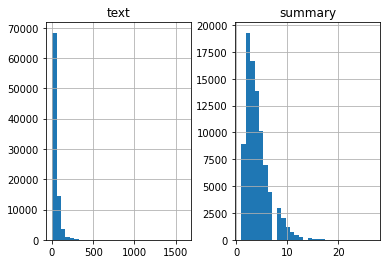

In [ ]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9784385186526621


In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9222654835204636


In [ ]:
max_text_len=100
max_summary_len=10

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
df[['summary','text']][:3]

,summary,text
0,sostok good quality dog food eostok,bought several Vitality canned dog food products found good quality. The product looks like stew processed meat smells better. Labrador finicky appreciates product better most.
1,sostok not as advertised eostok,"Product arrived labeled Jumbo Salted Peanuts...the peanuts actually small sized unsalted. Not sure error vendor intended represent product ""Jumbo""."
2,sostok delight says it all eostok,"This confection around centuries. light, pillowy citrus gelatin nuts case Filberts. And cut tiny squares liberally coated powdered sugar. And tiny mouthful heaven. Not chewy, flavorful. highly rec..."


In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.05403015335504
Total Coverage of rare words: 1.6131373448282784


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

16203

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.06267452683835
Total Coverage of rare words: 4.026943241284531


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:

y_tokenizer.word_counts['sostok'],len(y_tr)

(72120, 72120)

In [ ]:
y_tr

array([[   1,    5,   99, ...,    0,    0,    0],
       [   1,   12,   14, ...,    2,    0,    0],
       [   1,   39,    4, ...,    0,    0,    0],
       ...,
       [   1, 1960,  162, ...,   30,    2,    0],
       [   1,  283,   16, ...,    0,    0,    0],
       [   1,  643,    6, ...,   18,    2,    0]], dtype=int32)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
words_input = x_tokenizer.word_index

In [ ]:
len(x_tokenizer.word_index)

46363

In [ ]:
DIMENSIONS=100
input_embedding_matrix = np.zeros((x_voc, DIMENSIONS))
for word, k in words_input.items():
  if k < x_voc:
    embedding_vector = word2Vec.get(word)
    if embedding_vector is not None:
      input_embedding_matrix[k] = embedding_vector

In [ ]:
target_embedding_matrix = np.zeros((y_voc, DIMENSIONS))
for word, k in words_input.items():
  if k < y_voc:
    embedding_vector = word2Vec.get(word)
    if embedding_vector is not None:
      target_embedding_matrix[k] = embedding_vector

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [ ]:
x_voc

15429

In [ ]:
# def softmax_over_time(x):
#   assert(K.ndim(x) > 2)
#   e = K.exp(x - K.max(x, axis=1, keepdims=True))
#   s = K.sum(e, axis=1, keepdims=True)
#   return e / s

In [ ]:
# atten_layer_repeat = RepeatVector(max_text_len)
# atten_concatenate = Concatenate(axis=-1)
# atten_dense1 = Dense(30, activation='tanh')
# atten_dense2 = Dense(1, activation=softmax_over_time)
# attn_dot = Dot(axes=1)

In [ ]:
# def attention_procedure(h, st_1):
#   st_1 = atten_layer_repeat(st_1)
#   x = atten_concatenate([h, st_1])
#   x = atten_dense1(x)
#   alphas = atten_dense2(x)
#   context = attn_dot([alphas,h])
#   return context

In [ ]:
# st_0 = Input(shape=(latent_dim,))
# c_0 = Input(shape=(latent_dim,))
# context_last_word_concat_layer = Concatenate(axis=2)

In [ ]:
# def stack_and_transpose(x):
#   x = K.stack(x) 
#   x = K.permute_dimensions(x, pattern=(1, 0, 2)) 
#   return x

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300


# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, DIMENSIONS, weights=[input_embedding_matrix],trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, f_state_h1, f_state_c1, b_state_h1,b_state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output2, f_state_h2, f_state_c2 , b_state_h2 ,b_state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4))
encoder_outputs, f_state_h, f_state_c, b_state_h , b_state_c = encoder_lstm3(encoder_output2)

state_h = Concatenate()([f_state_h, b_state_h])
state_c = Concatenate()([f_state_c, b_state_c])


encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, DIMENSIONS, weights=[target_embedding_matrix],trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# #context
# s = st_0
# c = c_0
# outputs = []
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
# decoder_dense_layer = Dense(y_voc, activation='softmax')
# for i in range(max_summary_len):
#   context = attention_procedure(encoder_outputs, s)

#   selector = Lambda(lambda x: x[:, i:i+1])
#   xt = selector(dec_emb)
#   decoder_lstm_input = context_last_word_concat_layer([context, xt])
  
  
#   decoder_lstm_output, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s,c])

  
#   decoder_output = decoder_dense_layer(decoder_lstm_output)
#   outputs.append(decoder_output)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)

# stacker = Lambda(stack_and_transpose)
# outputs = stacker(outputs)

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# attn_out, attn_states = attn_layer([encoder_outputs,outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder, attn_out])


#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

# model = Model(
#   inputs=[
#     encoder_inputs,
#     decoder_inputs,
#     st_0, 
#     c_0,
#   ],
#   outputs=outputs
# )

# model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     1620300     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 100, 600), ( 962400      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 100, 600), ( 2162400     bidirectional[0][0]              
_______________________________________________________________________________________

In [ ]:
# my_callbacks = [
#     ModelCheckpoint(filepath = 'my_model.h5', 
#     verbose=1, save_best_only=True, save_weights_only=False) 
#     ]

# model.load_weights('/content/gdrive/My Drive/MyCNN/epochs:001-val_acc:0.672.hdf5')

In [ ]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/MyCNN/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
from keras import metrics 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es,callbacks_list],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
216/555 [==========>...................] - ETA: 12:31 - loss: 2.7421 - acc: 0.6022

In [ ]:
# model.save('saved_model/my_model') 


In [ ]:
# !ls saved_model

In [ ]:
# new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
# new_model.summary()

In [ ]:
# # Evaluate the restored model
# loss, acc = new_model.evaluate([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:],verbose=2)
# print(acc)
# print('Restored model, accuracy: {:5.2f}%'.format(100*acc))
# print(new_model.predict([x_val,y_val[:,:-1]]).shape)

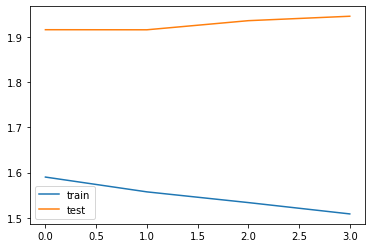

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
idx2word = {v:k for k, v in target_word_index.items()}
idx2word

{1: 'sostok',
 2: 'eostok',
 3: 'great',
 4: 'good',
 5: 'the',
 6: 'for',
 7: 'not',
 8: 'best',
 9: 'and',
 10: 'it',
 11: 'my',
 12: 'love',
 13: 'but',
 14: 'this',
 15: 'coffee',
 16: 'tea',
 17: 'product',
 18: 'to',
 19: 'is',
 20: 'delicious',
 21: 'of',
 22: 'taste',
 23: 'very',
 24: 'dog',
 25: 'flavor',
 26: 'excellent',
 27: 'like',
 28: 'tasty',
 29: 'in',
 30: 'these',
 31: 'yummy',
 32: 'food',
 33: 'price',
 34: 'too',
 35: 'favorite',
 36: 'ever',
 37: 'you',
 38: 'with',
 39: 'so',
 40: 'as',
 41: 'loves',
 42: 'dogs',
 43: 'snack',
 44: 'stuff',
 45: 'on',
 46: 'are',
 47: 'better',
 48: 'just',
 49: 'healthy',
 50: 'awesome',
 51: 'chocolate',
 52: 'no',
 53: 'have',
 54: 'free',
 55: 'nice',
 56: 'yum',
 57: 'tastes',
 58: 'perfect',
 59: 'than',
 60: 'them',
 61: 'what',
 62: 'sweet',
 63: 'really',
 64: 'bad',
 65: 'treat',
 66: 'wonderful',
 67: 'tasting',
 68: 'quality',
 69: 'at',
 70: 'one',
 71: 'all',
 72: 'buy',
 73: 'treats',
 74: 'me',
 75: 'cat',
 76: 

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_input=[decoder_state_input_h,decoder_state_input_c]
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_input)

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
from numpy import array
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # data  = output_tokens
        # data = array(data)
        
        # sampled_token = beam_decoder(data,3)
        # print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.replace('sostok','')

In [ ]:
from math import log
def beam_decoder(data, k):
	sequences = [[list(), 0.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		print(len(sequences))
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
		
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
import nltk
OSummary = []
PSummary = []
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    OSummary.append(seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    PSummary.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))
#     BLEUscore = nltk.translate.bleu_score.sentence_bleu([seq2summary(y_tr[i])],decode_sequence(x_tr[i].reshape(1,max_text_len)))
#     print(BLEUscore)
    print("\n")

Review: used get local grocery cat adores moved cross country mail order cat went hunger strike supply move ran acquired cats adore stuff two especially like soupy texture sometimes spoon kibble cats snarf primary food cats dessert served twice daily morning evening kibble however think stuff best thing ever prefer anything name way people food 
Original summary: the cats dessert 
Predicted summary:  my cats love it


Review: love cereal tastes wonderful enjoy much sometimes crave eat day 
Original summary: love this cereal chocolate is delicious 
Predicted summary:  love this cereal


Review: ramen opinion taste overly unique seafood flavor would recommend flavor typical chicken beef flavor tried one would really good 
Original summary: so good 
Predicted summary:  good but not great


Review: dried berries exactly like dried berries breakfast cereals put yogurt regular corn flakes think good buy 
Original summary: great 
Predicted summary:  great


Review: tried couple different hot 

In [ ]:
! pip install rouge
from rouge import Rouge
score = Rouge()

In [ ]:
while ' ' in PSummary:
    PSummary.remove(' ')
    
PSummary

[' my cats love it',
 ' love this cereal',
 ' good but not great',
 ' great',
 ' hot chocolate hot chocolate',
 ' great treats',
 ' not bad not great',
 ' good stuff',
 ' delicious',
 ' green tea',
 ' my dog loves it',
 ' pork shake',
 ' best tasting soft licorice',
 ' delicious',
 ' great flavor',
 ' my favorite',
 ' good coffee',
 ' not for me',
 ' not bad',
 ' great treats',
 ' good buy',
 ' great product',
 ' the best',
 ' not for large dogs',
 ' illy issimo coffee drink',
 ' baby loves it',
 ' delicious but',
 ' not as good as the mints',
 ' good coffee',
 ' delicious',
 ' not durable enough toy',
 ' dog loves it',
 ' my cats love this food',
 ' cats love it',
 ' great chews',
 ' not sure if it is from to',
 ' the best earl grey tea ever',
 ' great for the',
 ' bold but not bitter',
 ' delicious',
 ' bitter',
 ' great product',
 ' great peanuts',
 ' great tasting iced tea',
 ' yummy',
 ' great for plants',
 ' syrup',
 ' the best',
 ' pizza',
 ' surprisingly good',
 ' excellent',
 

In [ ]:
print(len(OSummary))
print(len(PSummary))


100
100


In [ ]:
while '' in OSummary:
    OSummary.remove('')

OSummary

['the cats dessert ',
 'love this cereal chocolate is delicious ',
 'so good ',
 'great ',
 'to have around for the kids guests and winter ',
 'zuke mini naturals ',
 'pretty good dark roast ',
 'good and easy to use ',
 'delicious ',
 'great tasting well priced green tea ',
 'organic non corn based treats over the top ',
 'after all these years it still tastes wonderful ',
 'disappointing very soft and too sweet ',
 'awesome ',
 'mmmmm good ',
 'community is the best ',
 'italian roast cup packs for keurig brewers pack of ',
 'way overpriced ',
 'deep saves these pork rinds ',
 'nice treats ',
 'good buy ',
 'great ',
 'good as ',
 'the new favorite ',
 'caffeine kick without the stomach burn ',
 'kids love these ',
 'yummy ',
 'real might have tasted better ',
 'never will purchase again ',
 'wonderful breakfast bar ',
 'good food toy for the ',
 'fun for you and your dog ',
 'great service from vendor great product ',
 'cats like it ',
 'oral hygiene dog chews ',
 'okay ',
 'twining

In [ ]:
[score.get_scores(OSummary,PSummary,avg = True)]

[{'rouge-1': {'f': 0.19558224919159925,
   'p': 0.17689682539682536,
   'r': 0.2547619047619047},
  'rouge-2': {'f': 0.049603174258191614,
   'p': 0.0435,
   'r': 0.06833333333333334},
  'rouge-l': {'f': 0.19561904572593738,
   'p': 0.1768611111111111,
   'r': 0.25416666666666665}}]

In [ ]:
avg=[]
a=0
for i in range(0,99):
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([OSummary[i]],PSummary[i])
    avg.append(BLEUscore)

for i in avg:
    a=a+i


print(a/99 *100)

35.13953321487919


In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer()

# sentence = ("""My little Chihuahua and Jack Russell mix just loves these! She 
# gobbles them up! They are a perfect
# size for her small mouth. According
# to her, they are very tasty.""","")
# model = ("My Dog Loves Them!","")
# summary = ("Chihuahua mix perfect","")

# tfidf_matrix_sentence = tfidf_vectorizer.fit_transform(sentence) 
# tfidf_matrix_model = tfidf_vectorizer.transform(model) 
# tfidf_matrix_summary = tfidf_vectorizer.transform(summary) 


# cosine = cosine_similarity(tfidf_matrix_sentence, tfidf_matrix_model)
# print(cosine)

# cosine = cosine_similarity(tfidf_matrix_sentence, tfidf_matrix_summary)
# print(cosine)